# Linear probe on embeddings

In [1]:
# Core Libraries
import os
import glob
import itertools

# Data Handling
import numpy as np
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

# Progress Bar
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import export_graphviz
from IPython.display import Image
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

# Statistics
from scipy.stats import skew, kurtosis, randint

# Modeling
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    average_precision_score,
    recall_score,
    confusion_matrix,
    roc_auc_score,
)
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model


In [2]:

static_variables = ['RecordID', 'Age', 'Gender', 'Height', 'ICUType', 'Weight']

static_variables.remove('ICUType')

static_variables_we_want = ['Age', 'Gender', 'Height', 'Weight']
all_variables = ['Weight', 'Age', 'TroponinI', 'DiasABP', 'MechVent', 'HCO3', 'Cholesterol', 'HCT', 'SaO2', 'WBC', 'SysABP', 'Urine', 'ICUType', 'Gender', 'ALP', 'Creatinine', 'K', 'AST', 'Glucose', 'RespRate', 'MAP', 'FiO2', 'BUN', 'Na', 'Bilirubin', 'TroponinT', 'PaCO2', 'Height', 'GCS', 'HR', 'pH', 'PaO2', 'Lactate', 'ALT', 'NISysABP', 'RecordID', 'Platelets', 'Temp', 'Mg', 'NIDiasABP', 'Albumin', 'NIMAP']
dyn_variables = [x for x in all_variables if x not in static_variables]
dyn_variables.remove('ICUType')
dyn_variables.append('Weight_VAR')
len(dyn_variables), len(static_variables_we_want)

initial_column_lists = static_variables_we_want + dyn_variables

In [3]:
# open embedding_palib_a.csv in data_4
# df_a_emb = pd.read_csv('data_4/embedding_feat_for_a.csv')
# df_c_emb = pd.read_csv('data_4/embedding_feat_for_c.csv')
# outcomes = pd.read_csv('data/outcomes.csv')

# read data_4/embedding_feat_for_a.parquet and data_4/embedding_feat_for_c.parquet
df_a_emb =pd.read_parquet('data_4/embedding_feat_for_a.parquet', engine='pyarrow')
df_c_emb =pd.read_parquet('data_4/embedding_feat_for_c.parquet', engine='pyarrow')


In [4]:
df_a_emb

,RecordID,1,2,3,4,5,6,7,8,9,...,2563,2564,2565,2566,2567,2568,2569,2570,2571,2572
0,132539.0,-0.012958,-0.025266,0.012520,-0.001375,0.005503,-0.012004,0.014681,0.006238,-0.011897,...,0.006354,0.009037,-0.036155,0.001454,-0.014744,0.014636,-0.008853,-0.007036,0.026337,-0.015953
1,132540.0,-0.017817,-0.030658,0.005865,0.005403,0.015092,-0.008452,0.018519,0.010844,-0.010185,...,0.013771,0.009984,-0.039191,0.007461,-0.012160,0.011378,-0.001824,-0.007559,0.021885,-0.011404
2,132541.0,-0.015878,-0.026322,0.013118,0.003591,0.014589,-0.009240,0.021075,0.011062,-0.012841,...,0.013237,0.015146,-0.041321,0.008169,-0.013362,0.014106,0.001183,-0.005512,0.021803,-0.007761
3,132543.0,-0.011936,-0.027855,0.014267,0.001576,0.006452,-0.012533,0.014743,0.007592,-0.017981,...,0.007355,0.013648,-0.033635,0.004903,-0.013564,0.011286,-0.004052,-0.006081,0.020006,-0.014936
4,132545.0,-0.007641,-0.023596,0.011013,0.001347,0.008552,-0.010707,0.012390,0.008800,-0.010009,...,0.010582,0.007647,-0.037963,0.002943,-0.013905,0.013070,-0.012368,-0.002569,0.028014,-0.019369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,142665.0,-0.018376,-0.031934,0.015731,0.004010,0.012903,-0.012126,0.011604,0.009187,-0.006025,...,0.020611,0.009163,-0.039874,0.004353,-0.011682,0.011088,0.000942,-0.002153,0.023589,-0.011112
3996,142667.0,-0.009730,-0.025776,0.013776,0.001556,0.006456,-0.011007,0.016115,0.011923,-0.012523,...,0.006684,0.013796,-0.037763,0.004030,-0.015971,0.012109,-0.004336,-0.007387,0.021898,-0.018094
3997,142670.0,-0.015574,-0.030552,0.009309,0.008621,0.012472,-0.006136,0.015999,0.011753,-0.007887,...,0.017803,0.010596,-0.039910,0.006488,-0.015498,0.014059,-0.002012,-0.006745,0.021894,-0.010154
3998,142671.0,-0.016314,-0.029802,0.009515,-0.001161,0.012079,-0.010411,0.018202,0.010965,-0.011188,...,0.009599,0.010622,-0.032424,0.007681,-0.011380,0.011864,0.000803,-0.001929,0.022455,-0.010350


In [5]:
#  load outcomes.csv
outcomes = pd.read_csv('data/outcomes.csv')

In [6]:
# df_a_emb
outcomes_a = outcomes[outcomes['RecordID'].isin(df_a_emb['RecordID'])]
outcomes_c = outcomes[outcomes['RecordID'].isin(df_c_emb['RecordID'])]

In [7]:
outcomes_a

,RecordID,In-hospital_death
0,132539,0
1,132540,0
2,132541,0
3,132543,0
4,132545,0
...,...,...
3995,142665,0
3996,142667,0
3997,142670,0
3998,142671,1


In [8]:
# Scaling
# --- scaling Data ---
feature_cols = [col for col in df_a_emb.columns if col != 'RecordID']

scaler = StandardScaler()
scaler.fit(df_a_emb[feature_cols])

df_a_scaled = pd.DataFrame(scaler.transform(df_a_emb[feature_cols]), columns=feature_cols)
df_c_scaled = pd.DataFrame(scaler.transform(df_c_emb[feature_cols]), columns=feature_cols)


### We try both a balanced and no class weight model

In [9]:
# train logistic regression model on df_a_emb and df_c_emb
logr = linear_model.LogisticRegression(max_iter=1000)
logr_bal = linear_model.LogisticRegression(max_iter = 1000, class_weight='balanced')
# logr = linear_model.LogisticRegression()
logr.fit(df_a_scaled, outcomes_a['In-hospital_death'])
logr_bal.fit(df_a_scaled, outcomes_a['In-hospital_death'])

LogisticRegression(class_weight='balanced', max_iter=1000)

### Display coefficients of logistic regression models

Text(0.5, 1.0, 'Histogram of coefficients of logistic regression model, balanced weights')

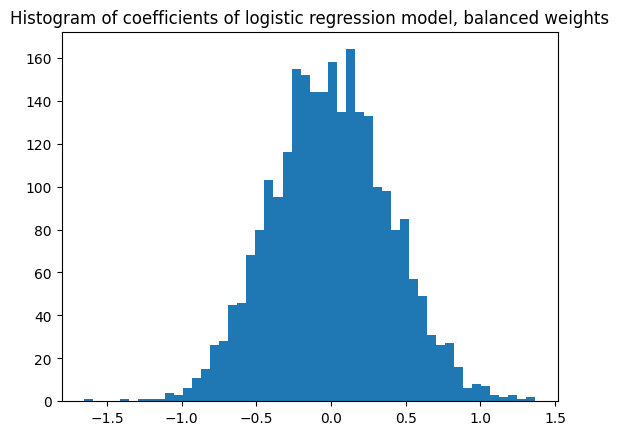

In [10]:

logr_bal.coef_


#  histogram of coefficients of logistic regression model
plt.hist(logr_bal.coef_[0], bins=50)
plt.title('Histogram of coefficients of logistic regression model, balanced weights')



Text(0.5, 1.0, 'Histogram of coefficients of logistic regression model')

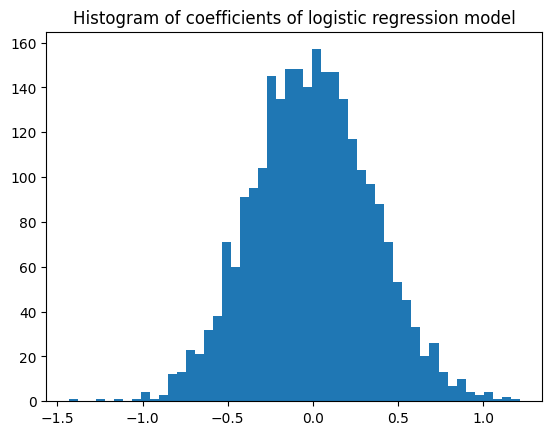

In [11]:
# display coefficients of logistic regression model
logr.coef_


#  histogram of coefficients of logistic regression model
plt.hist(logr.coef_[0], bins=50) 
plt.title('Histogram of coefficients of logistic regression model')



In [12]:
# pred on df_c_emb
pred = logr.predict(df_c_scaled)
pred_proba = logr.predict_proba(df_c_scaled)[:, 1]

pred_bal = logr_bal.predict(df_c_scaled)
pred_proba_bal = logr_bal.predict_proba(df_c_scaled)[:, 1]

ROC AUC Score: 0.61 Average Precision Score: 0.21


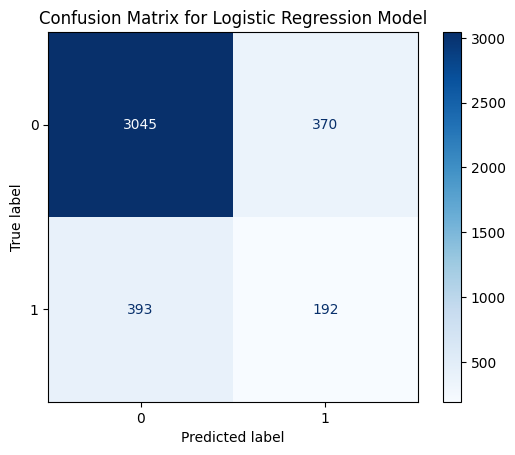

In [13]:
roc_auc_ = roc_auc_score(outcomes_c['In-hospital_death'], pred)

average_precision_ = average_precision_score(outcomes_c['In-hospital_death'], pred)
print('ROC AUC Score:', round(roc_auc_,3), 'Average Precision Score:', round(average_precision_,3))

cm = confusion_matrix(outcomes_c['In-hospital_death'], pred, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

ROC AUC Score: 0.626 Average Precision Score: 0.213


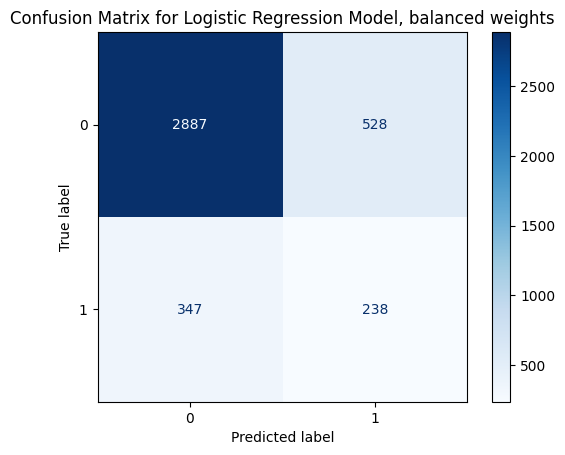

In [14]:
roc_auc_ = roc_auc_score(outcomes_c['In-hospital_death'], pred_bal)

average_precision_ = average_precision_score(outcomes_c['In-hospital_death'], pred_bal, )
print('ROC AUC Score:', round(roc_auc_,3), 'Average Precision Score:', round(average_precision_,3))

cm = confusion_matrix(outcomes_c['In-hospital_death'], pred_bal, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Model, balanced weights')
plt.show()

### Perform grid search on regularization strengh

In [15]:
param_grid = {'C': np.logspace(-3, 3, 7)}
grid = GridSearchCV(LogisticRegression(max_iter=600, class_weight='balanced'),
                    param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(df_a_scaled, outcomes_a['In-hospital_death'])


GridSearchCV(cv=5,
             estimator=LogisticRegression(class_weight='balanced',
                                          max_iter=600),
             n_jobs=-1,
             param_grid={'C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             scoring='roc_auc')

In [16]:

best_log_reg = grid.best_estimator_
print("Best C:", grid.best_params_['C'])


Best C: 0.01


ROC AUC Score: 0.69 Average Precision Score: 0.251


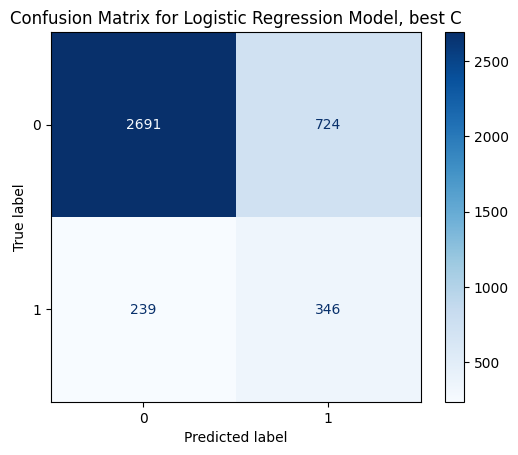

In [17]:
# train on best_log_reg
best_log_reg.fit(df_a_scaled, outcomes_a['In-hospital_death'])
# pred on df_c_emb
pred = best_log_reg.predict(df_c_scaled)
pred_proba = best_log_reg.predict_proba(df_c_scaled)[:, 1]

roc_auc_ = roc_auc_score(outcomes_c['In-hospital_death'], pred) 
average_precision_ = average_precision_score(outcomes_c['In-hospital_death'], pred)
print('ROC AUC Score:', round(roc_auc_,3), 'Average Precision Score:', round(average_precision_,3))
cm = confusion_matrix(outcomes_c['In-hospital_death'], pred, labels=[0, 1])
cm_display = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Logistic Regression Model, best C')

plt.show()

### TSNE


In [18]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score
import plotly.express as px

features = df_a_emb.loc[:, '1':str(len(df_a_emb.columns)-1)].values

tsne = TSNE(n_components=2, random_state=0)
projections = tsne.fit_transform(features)

# Create DataFrame with projections + label
df_tsne = pd.DataFrame(projections, columns=['TSNE-1', 'TSNE-2'])
df_tsne['In-hospital_death'] = outcomes_a['In-hospital_death'].values

# Save to CSV (to be plotted later)
df_tsne.to_csv('data_4/df_tsne.csv', index=False)
print("Saved t-SNE projection to csv")


Saved t-SNE projection to csv


In [19]:

df_tsne = pd.read_csv('data_4/df_tsne.csv')


# plot df_tsne TSNE-1 over TSNE-2, color by In-hospital_death
fig = px.scatter(df_tsne, x='TSNE-1', y='TSNE-2', color='In-hospital_death', title='t-SNE projection of embedding space')
fig.update_traces(marker=dict(size=5), selector=dict(mode='markers'))
fig.update_layout(title_x=0.5, title_y=0.95, title_font=dict(size=20), width=800, height=600)

fig.show()


In [20]:
embeddings =  df_tsne.values

sil_score = silhouette_score(embeddings, outcomes_a['In-hospital_death'].values)
print("Silhouette Score:", sil_score)

Silhouette Score: 0.002426634418991521
